### Library and file imports 

In [1]:
import glob
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, precision_score, f1_score

In [2]:
path_to_normal_operation_files = r"./data/0"
path_to_flow_instability_files = r"./data/4"

all_normal_operation_files = glob.glob(
    os.path.join(path_to_normal_operation_files, "*.csv")
)
all_flow_instability_files = glob.glob(
    os.path.join(path_to_flow_instability_files, "*.csv")
)

### Base samples

In [3]:
list_files = []
for filename in all_normal_operation_files:
    df_normal = pd.read_csv(filename, index_col=None, header=0)
    list_files.append(df_normal)

normal_frame = pd.concat(list_files, axis=0)
del list_files, df_normal
normal_frame.head(3)

,timestamp,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
0,2017-02-01 02:02:07.000000,0.0,10092110.0,119.0944,1609800.0,84.59782,1564147.0,NaN,0.0,0.0
1,2017-02-01 02:02:08.000000,0.0,10092000.0,119.0944,1618206.0,84.58997,1564148.0,NaN,0.0,0.0
2,2017-02-01 02:02:09.000000,0.0,10091890.0,119.0944,1626612.0,84.58213,1564148.0,NaN,0.0,0.0


In [4]:
list_files = []
for filename in all_flow_instability_files:
    df_anomaly = pd.read_csv(filename, index_col=None, header=0)
    list_files.append(df_anomaly)

flow_instability_frame = pd.concat(list_files, axis=0)
del list_files, df_anomaly
flow_instability_frame.head(3)

,timestamp,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
0,2017-03-16 12:02:03.000000,38265830.0,13654450.0,117.1953,6029680.0,68.64587,3283309.0,NaN,0.0,4
1,2017-03-16 12:02:04.000000,38265830.0,13654520.0,117.1947,6030228.0,68.64333,3283309.0,NaN,0.0,4
2,2017-03-16 12:02:05.000000,38265830.0,13654580.0,117.1942,6030777.0,68.64080,3283308.0,NaN,0.0,4


In [5]:
df_source = pd.concat([normal_frame, flow_instability_frame])
del normal_frame, flow_instability_frame

### Preprocessing of the whole base

In [6]:
# observations without classification are discarded
target_class = "class"
df_pipe = df_source.dropna(subset=[target_class])

X_pipe = df_pipe.drop(target_class, axis=1)
y_pipe = df_pipe.loc[:, target_class]

del df_pipe

X_pipe_train, X_pipe_test, y_pipe_train, y_pipe_test = train_test_split(
    X_pipe, y_pipe, test_size=0.2, random_state=666
)

del X_pipe, y_pipe

### Pipeline

#### Assembling Pipeline

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FunctionTransformer

In [8]:
columns_to_drop = ["timestamp", "T-JUS-CKGL"]

drop_function = FunctionTransformer(lambda x: x.drop(columns=columns_to_drop, axis=1))

fill_mean = SimpleImputer(missing_values=np.nan, strategy="mean")

pipe = Pipeline(
    steps=[
        ("dropout", drop_function),
        ("fillna", fill_mean),
        ("transform", MinMaxScaler()),
        ("clf", GaussianNB()),
    ]
)

#### Tuning Hyperparameters and Tracking Experiment with MLFlow

In [9]:
import mlflow
import copy

mlflow.set_experiment("mack-tac-experiment")

<Experiment: artifact_location='file:///d:/Users/Lucas/Documents/workspace/defante/api-mack-tac-mlops/mlruns/219002891498167879', creation_time=1728341596398, experiment_id='219002891498167879', last_update_time=1728341596398, lifecycle_stage='active', name='mack-tac-experiment', tags={}>

In [ ]:
if False:
    mlflow.start_run()

    mlflow.set_tags({"model": "GaussianNB", "class": "experiment"})

    var_smoothings = np.logspace(-9, 0, num=10)

    for value in var_smoothings:

        mlflow.start_run(nested=True)

        print(f"Fitting for var_smoothing={value}")

        mlflow.log_param("var_smoothing", value)

        experiment_pipe = copy.deepcopy(pipe)

        experiment_pipe.set_params(clf__var_smoothing=value)

        experiment_pipe.fit(X_pipe_train, y_pipe_train)

        experiment_predictions = experiment_pipe.predict(X_pipe_test)

        mlflow.log_metrics(
            {
                "accuracy": (experiment_pipe.score(X_pipe_test, y_pipe_test)),
                "recall": (
                    recall_score(
                        y_pipe_test.values, experiment_predictions, pos_label=4
                    )
                ),
                "precision": (
                    precision_score(
                        y_pipe_test.values, experiment_predictions, pos_label=4
                    )
                ),
                "f1-score": (
                    f1_score(y_pipe_test.values, experiment_predictions, pos_label=4)
                ),
            }
        )

        mlflow.end_run()

    mlflow.end_run()

#### Metrics of Optimal Model

After experiment analysis, none of the values used for var_smoothing had a significant impact in the model performance, so for the optimal model we'll use the default value, which is exp(-9).

In [17]:
with mlflow.start_run():
    mlflow.set_tags({"model": "GaussianNB", "class": "optimal"})

    pipe.fit(X_pipe_train, y_pipe_train)

    predictions = pipe.predict(X_pipe_test)

    metrics_data = {
        "accuracy": (pipe.score(X_pipe_test, y_pipe_test)),
        "recall": (recall_score(y_pipe_test.values, predictions, pos_label=4)),
        "precision": (precision_score(y_pipe_test.values, predictions, pos_label=4)),
        "f1-score": (f1_score(y_pipe_test.values, predictions, pos_label=4)),
    }

    mlflow.log_metrics(metrics_data)
    mlflow.sklearn.log_model(pipe, "model")

2024/11/17 21:48:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [18]:
# add confusion matrix
metrics_data["cm"] = confusion_matrix(y_pipe_test, predictions)

print(metrics_data)

{'accuracy': 0.9228895224123633, 'recall': np.float64(0.6572493417054892), 'precision': np.float64(0.9576969278401025), 'f1-score': np.float64(0.779525222908361), 'cm': array([[1872305,   14333],
       [ 169216,  324484]])}


In [19]:
with open("results/metrics.txt", "w") as outfile:
    outfile.write(
        f"\nAccuracy = {round(metrics_data['accuracy'], 4)}, "
        + f"Recall = {round(metrics_data['recall'], 4)}, "
        + f"Precision = {round(metrics_data['precision'], 4)}, "
        + f"F1 Score = {round(metrics_data['f1-score'], 4)}"
    )

#### Results Report

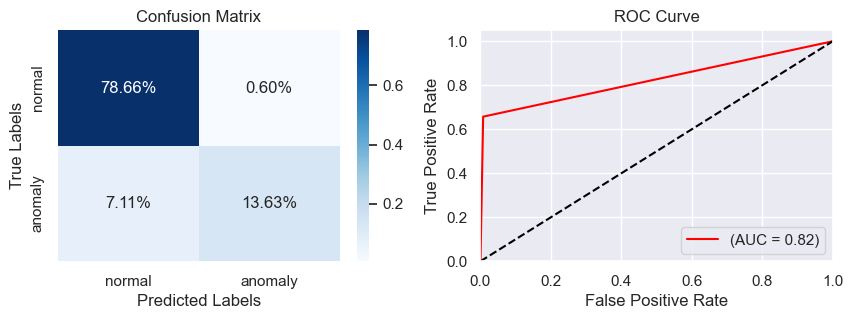

In [20]:
sns.set_theme()
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.heatmap(
    metrics_data["cm"] / np.sum(metrics_data["cm"]),
    annot=True,
    fmt=".2%",
    cmap="Blues",
    ax=axs[0],
)
axs[0].set_xlabel("Predicted Labels")
axs[0].set_ylabel("True Labels")
axs[0].xaxis.set_ticklabels(["normal", "anomaly"])
axs[0].yaxis.set_ticklabels(["normal", "anomaly"])
axs[0].set_title("Confusion Matrix")

fpr, tpr, thresholds = roc_curve(y_pipe_test, predictions, pos_label=4)
auc_score = auc(fpr, tpr)

axs[1].plot(fpr, tpr, label=f"(AUC = {auc_score:.2f})", color="red")
axs[1].plot([0, 1], [0, 1], color="black", linestyle="--")
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].set_title(f"ROC Curve")
axs[1].legend(loc="lower right")

plt.plot()
plt.savefig("results/model_results.png", dpi=120)

#### Saving Model

In [21]:
from cloudpickle import dump

In [22]:
model_file = "model/anomaly_detector_pipeline.pkl"

with open(model_file, "wb") as pkl_file:
    dump(pipe, pkl_file)

### Model Management with MLFlow

In [23]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

In [24]:
client.search_experiments(filter_string="name = 'mack-tac-experiment'")

[<Experiment: artifact_location='file:///d:/Users/Lucas/Documents/workspace/defante/api-mack-tac-mlops/mlruns/219002891498167879', creation_time=1728341596398, experiment_id='219002891498167879', last_update_time=1728341596398, lifecycle_stage='active', name='mack-tac-experiment', tags={}>]

In [ ]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids="219002891498167879",
    filter_string="tags.class = 'optimal'",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["created DESC"],
)

In [26]:
for run in runs:
    print(f"run id: {run.info.run_id}, precision: {run.data.metrics['precision']:.4f}")

run id: 0bace3e396614de59b973e540c263959, precision: 0.9577
run id: 9e4fc52a9fd54ed5a1cccd2b7a979862, precision: 0.9577
run id: 81cdc292d93e4a3e9511d6a86cba519c, precision: 0.9577
run id: 1cd0e1523a984691a74a9720e0a75a07, precision: 0.9577
run id: 707389e2a35e499885ebf894a0b1fc07, precision: 0.9577


#### Model Registering

In [ ]:
run_id = "9e4fc52a9fd54ed5a1cccd2b7a979862"
model_uri = f"runs:/{run_id}/model"
model_name = "mack-tac-classificator"
mlflow.register_model(model_uri=model_uri, name=model_name)

Registered model 'mack-tac-classificator' already exists. Creating a new version of this model...
Created version '2' of model 'mack-tac-classificator'.


<ModelVersion: aliases=[], creation_timestamp=1731892032830, current_stage='None', description=None, last_updated_timestamp=1731892032830, name='mack-tac-classificator', run_id='9e4fc52a9fd54ed5a1cccd2b7a979862', run_link=None, source='file:///d:/Users/Lucas/Documents/workspace/defante/api-mack-tac-mlops/mlruns/219002891498167879/9e4fc52a9fd54ed5a1cccd2b7a979862/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [50]:
import warnings

warnings.filterwarnings(action="ignore", category=FutureWarning)

In [ ]:
list_latest_versions = client.get_latest_versions(name=model_name)

for versions in list_latest_versions:
    print(f"version: {versions.version}; stage: {versions.current_stage}")

version: 2; stage: Production
version: 1; stage: Archived


In [ ]:
model_version = 2
new_stage = "production"

#### Model Staging

In [ ]:
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=True,
)

<ModelVersion: aliases=[], creation_timestamp=1731892032830, current_stage='Production', description=None, last_updated_timestamp=1731892264053, name='mack-tac-classificator', run_id='9e4fc52a9fd54ed5a1cccd2b7a979862', run_link=None, source='file:///d:/Users/Lucas/Documents/workspace/defante/api-mack-tac-mlops/mlruns/219002891498167879/9e4fc52a9fd54ed5a1cccd2b7a979862/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [ ]:
from datetime import datetime

date = datetime.today()
client.update_model_version(
    name=model_name,
    version=model_version,
    description=f"The model version {model_version} was transitioned to {new_stage} on {date}.",
)

<ModelVersion: aliases=[], creation_timestamp=1731892032830, current_stage='Production', description=('The model version 2 was transitioned to production on 2024-11-17 '
 '22:18:33.934433.'), last_updated_timestamp=1731892713934, name='mack-tac-classificator', run_id='9e4fc52a9fd54ed5a1cccd2b7a979862', run_link=None, source='file:///d:/Users/Lucas/Documents/workspace/defante/api-mack-tac-mlops/mlruns/219002891498167879/9e4fc52a9fd54ed5a1cccd2b7a979862/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

#### Testing Model from Staged Source

In [72]:
def test_model(name, stage, XTest, YTest):
    model = mlflow.pyfunc.load_model(f"models:/{name}/{stage}")
    ypred = model.predict(XTest)
    metrics_data = {
        "accuracy": (pipe.score(XTest, YTest)),
        "recall": (recall_score(YTest.values, ypred, pos_label=4)),
        "precision": (precision_score(YTest.values, ypred, pos_label=4)),
        "f1-score": (f1_score(YTest.values, ypred, pos_label=4)),
    }
    print(metrics_data)


test_model(model_name, "production", X_pipe_test, y_pipe_test)

{'accuracy': 0.9228895224123633, 'recall': np.float64(0.6572493417054892), 'precision': np.float64(0.9576969278401025), 'f1-score': np.float64(0.779525222908361)}
